In [1]:
#pip install transformers torch

In [2]:
import pandas as pd
import re
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence

In [3]:
df= pd.read_csv('conversation_dataset.csv')
df.head(2)

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN


In [4]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [5]:
df['conversation'] = text_preprocess(list(df['conversation']))

In [6]:
df['category'].unique()

array(['first participant in conversation is deceiving the second one',
       'second participant in conversation is deceiving the first one',
       'both participants in conversation are deceiving each other',
       'none of participants in conversation try to deceive the other one'],
      dtype=object)

In [7]:
def category_to_label(j):
    if j == 'first participant in conversation is deceiving the second one':
        return 0
    elif j == 'second participant in conversation is deceiving the first one':
        return 1
    elif j == 'both participants in conversation are deceiving each other':
        return 2
    elif j== 'none of participants in conversation try to deceive the other one':
        return 3      
           
df['labels'] = df.category.apply(category_to_label)
df[['category','labels']]

,category,labels
0,first participant in conversation is deceiving...,0
1,second participant in conversation is deceivin...,1
2,both participants in conversation are deceivin...,2
3,none of participants in conversation try to de...,3
4,first participant in conversation is deceiving...,0
...,...,...
183,none of participants in conversation try to de...,3
184,first participant in conversation is deceiving...,0
185,second participant in conversation is deceivin...,1
186,both participants in conversation are deceivin...,2


In [8]:
# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: NVIDIA A100 80GB PCIe MIG 1g.10gb


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=4)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
class ConversationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
 
    def __len__(self):
        return len(self.texts)
 
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        chunks = self.chunk_text(text, self.max_length - 2)  # for special tokens
 
        input_ids = []
        attention_masks = []
 
        for chunk in chunks:
            # Encode each chunk
            inputs = self.tokenizer.encode_plus(chunk, add_special_tokens=True, max_length=self.max_length,
                                                padding='max_length', truncation=True, return_tensors="pt")
            input_ids.append(inputs['input_ids'][0])
            attention_masks.append(inputs['attention_mask'][0])
 
        return {
            'input_ids': torch.stack(input_ids),
            'attention_mask': torch.stack(attention_masks),
            'labels': torch.tensor(label)
        }
 
    def chunk_text(self, text, max_chunk_size):
        # Tokenize the text and chunk it
        tokens = self.tokenizer.tokenize(text)
        chunks = [tokens[i:i + max_chunk_size] for i in range(0, len(tokens), max_chunk_size)]
        return chunks

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(list(df['conversation']), list(df['labels']), test_size=0.3)
 
train_dataset = ConversationDataset(train_texts, train_labels, tokenizer)
val_dataset = ConversationDataset(val_texts, val_labels, tokenizer)

In [12]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['labels'] for item in batch])
 
    # Pad the sequences for each conversation
    input_ids_padded = [pad_sequence(seq, batch_first=True, padding_value=0) for seq in input_ids]
    attention_masks_padded = [pad_sequence(seq, batch_first=True, padding_value=0) for seq in attention_masks]
 
    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

In [13]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)

In [14]:
optimizer = AdamW(model.parameters(), lr=3e-5) 
#also add a scheduler 

/home/766619/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def process_dataloader(model, dataloader, optimizer, device, is_training):
    if is_training:
        model.train()
    else:
        model.eval()
 
    total_loss = 0
    true_labels, predictions = [], []
 
    for batch in dataloader:
        labels = batch['labels'].to(device)
        batch_loss = 0
        conversation_logits = []  # store logits for each conversation
 
        for i in range(len(batch['input_ids'])):
            input_ids_chunks = batch['input_ids'][i].to(device)
            attention_mask_chunks = batch['attention_mask'][i].to(device)
            conversation_labels = labels[i].unsqueeze(0).to(device)
 
            for j in range(input_ids_chunks.size(0)):
                input_ids = input_ids_chunks[j].unsqueeze(0)  # add batch dimension
                attention_mask = attention_mask_chunks[j].unsqueeze(0)  # add batch dimension
 
                if is_training:
                    optimizer.zero_grad()
 
                with torch.set_grad_enabled(is_training):
                    outputs = model(input_ids, attention_mask=attention_mask, labels=conversation_labels)
                    loss = outputs.loss
 
                    if is_training:
                        loss.backward()
                        optimizer.step()
 
                batch_loss += loss.item()
                conversation_logits.append(outputs.logits.detach().cpu())
 
            # aalculate average logits across chunks for a conversation
            avg_logits = torch.mean(torch.stack(conversation_logits), dim=0)
            true_labels.extend(conversation_labels.cpu().numpy())
            predictions.extend(torch.argmax(avg_logits, dim=1).numpy())
 
        # normalize the loss by the number of conversations
        total_loss += batch_loss / len(batch['input_ids'])
 
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
 
    return avg_loss, accuracy, f1

The labels are repeated for each chunk of a conversation, where the label applies to the entire conversation (not individual chunks), the loss calculation and accuracy measurements must be adjusted accordingly.

In [16]:
train_losses, train_accuracies, train_f1_scores = [], [], []
val_losses, val_accuracies, val_f1_scores = [], [], []
epochs = 2
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    train_loss, train_acc, train_f1 = process_dataloader(model, train_loader, optimizer, device, is_training=True)
    print(f'Train Loss: {train_loss}, Train Accuracy: {train_acc}, Train F1 Score: {train_f1}')
    val_loss, val_acc, val_f1 = process_dataloader(model, val_loader, None, device, is_training=False)
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, Validation F1 Score: {val_f1}')
     
    # append metrics to their respective lists for plotting later
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_f1_scores.append(train_f1)
 
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)


Epoch 1:
Train Loss: 2.926452033075632, Train Accuracy: 0.2366412213740458, Train F1 Score: 0.21742130524094075
Validation Loss: 2.96849512681365, Validation Accuracy: 0.15789473684210525, Validation F1 Score: 0.043062200956937795
Epoch 2:
Train Loss: 2.900651996772663, Train Accuracy: 0.32061068702290074, Train F1 Score: 0.21619364256221155
Validation Loss: 2.868146076798439, Validation Accuracy: 0.21052631578947367, Validation F1 Score: 0.07322654462242563


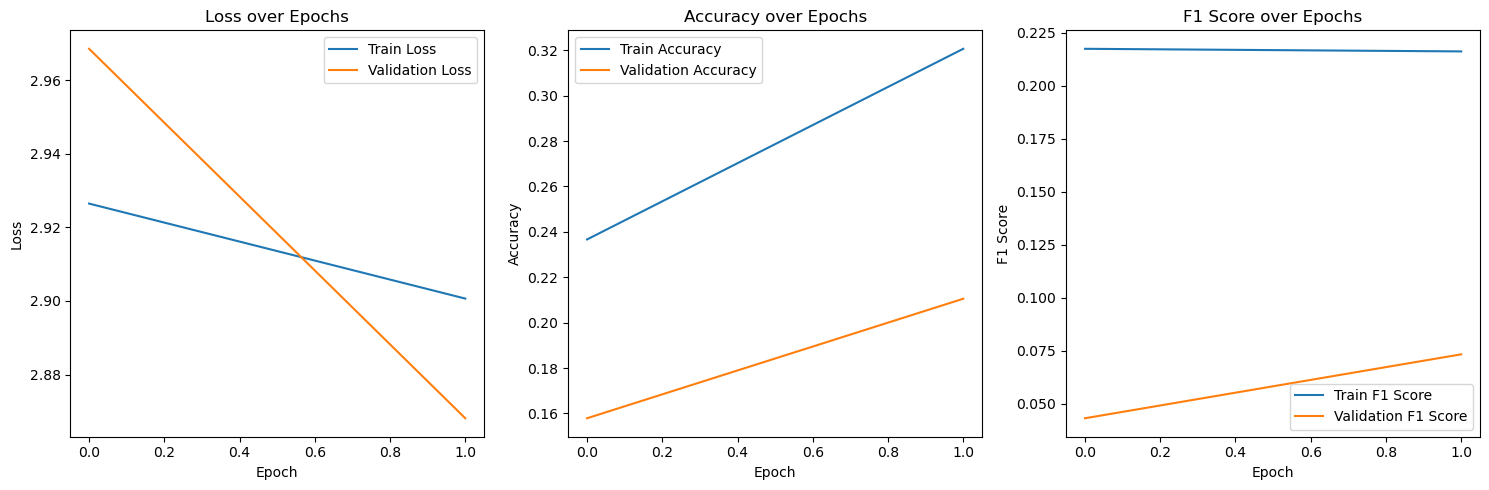

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
 
# training and validation loss
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_title('Loss over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
 
# training and validation accuracy
axs[1].plot(train_accuracies, label='Train Accuracy')
axs[1].plot(val_accuracies, label='Validation Accuracy')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
 
# training and validation F1 score
axs[2].plot(train_f1_scores, label='Train F1 Score')
axs[2].plot(val_f1_scores, label='Validation F1 Score')
axs[2].set_title('F1 Score over Epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('F1 Score')
axs[2].legend()
 
plt.tight_layout()
plt.savefig('Multiclass-BERT.png', dpi=300, bbox_inches='tight')
plt.show()